# Problem 2

In [1]:
## setup

# load libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split


# define custom data class
class WineData(Dataset):
    def __init__(self, data):
        # load dataset
        self.data = data
        self.header = self.data.columns.tolist()
        self.preds = torch.Tensor(self.data.drop("quality", axis=1).values)
        self.targets = torch.Tensor(self.data[["quality"]].values)
        
    def __len__(self):
        return len(self.preds)

    def __getitem__(self, rownum):
        preds = self.preds[rownum, :]
        target = self.targets[rownum, :]

        return preds, target
    

# load data
qual_r_raw = pd.read_csv("winequality-red.csv", delimiter=";", dtype="float")
qual_w_raw = pd.read_csv("winequality-white.csv", delimiter=";", dtype="float")

# split into training/test/validation data
qual_r_train, qual_r_other = train_test_split(qual_r_raw, train_size=0.64)
qual_r_val, qual_r_test = train_test_split(qual_r_other, train_size=0.16/(0.16+0.2))
                                           
qual_w_train, qual_w_other = train_test_split(qual_w_raw, train_size=0.64)
qual_w_val, qual_w_test = train_test_split(qual_w_other, train_size=0.16/(0.16+0.2))

# combine into final datasets
qual_train = pd.concat([qual_r_train, qual_w_train], axis=0)
qual_val = pd.concat([qual_r_val, qual_w_val], axis=0)
qual_test = pd.concat([qual_r_test, qual_w_test], axis=0)

In [2]:
# define model architecture

class WiNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.regression = nn.Sequential(
            nn.Linear(11, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.regression(x)
        return x

In [3]:
# set up model training

def train(model, train, val, epoch, gamma=0, eta=0.0005, N=32, opt="SGD"):
    # set up variable storing loss values, by batch/epoch    
    # set up loss function
    losses = []
    criterion = nn.MSELoss()
    
    # set optimizer
    if opt == "SGD":
        optimizer = optim.SGD(model.parameters(),lr=eta, momentum=0, weight_decay=gamma)
    elif opt == "RMSProp":
        optimizer = optim.RMSprop(model.parameters(), lr=eta, weight_decay=gamma)
    else:
        opt = "Adam"
        optimizer = optim.Adam(model.parameters(), lr=eta, weight_decay=gamma)
        
    train_loader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=N)
    
    # loop through batches
    i = 0
    for batch_id, (train_data, train_target) in enumerate(train_loader):
        optimizer.zero_grad()
        train_output = model(train_data)
        val_output = model(val.preds)
        
        loss = criterion(train_output, train_target)
        val_loss = criterion(val_output, val.targets)
        
        loss.backward()
    
        #StepLR(optimizer, step_size=30, gamma=gamma).step()
        optimizer.step()
        
        if batch_id == 0:
            losses = torch.Tensor([[1, batch_id, loss, val_loss]])
        else:
            losses = torch.cat((losses, torch.Tensor([[1, batch_id, loss, val_loss]])), dim=0)

        i += 1
    
    plt.figure()
    plt.plot(losses[:,1].numpy(), np.log(losses[:,2].numpy()), marker='')
    plt.plot(losses[:,1].numpy(), np.log(losses[:,3].numpy()), marker='')
    # plt.plot(losses[:,1].numpy(), losses[:,2].numpy(), marker='')
    # plt.plot(losses[:,1].numpy(), losses[:,3].numpy(), marker='')
    plt.xlabel("Batch #")
    plt.ylabel("Log-loss (MSE)")
    plt.legend(["Training loss", "Validation loss"])
    plt.title(f"Training loss vs. mini-batch ({opt})")
    plt.show()
    
    return losses, model, plt.gcf

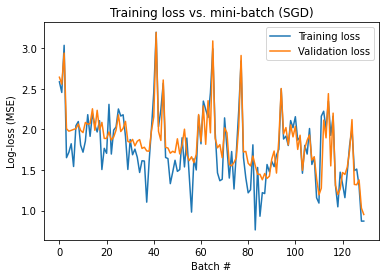

In [4]:
train_dataset = WineData(qual_train)
val_dataset = WineData(qual_val)
model =  WiNet()
epoch = 1
losses, model_trained, plot = train(model, train_dataset, val_dataset, 1)

# Problem 3

In [16]:
# setup
from torch.optim.lr_scheduler import StepLR

gammas = [0.1, 0.001, 0.0001]
etas = [10**-2, 10**-3, 10**-4]
Ns = [16, 160, 1600]

# Weight decay test
## RMSProp optimizer

gamma=0.001, eta=0.01, batch_size=160


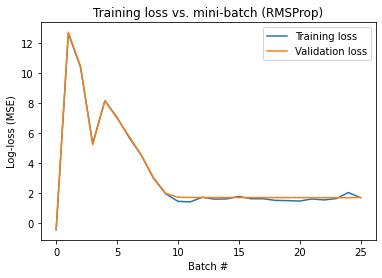

gamma=0.001, eta=0.001, batch_size=160


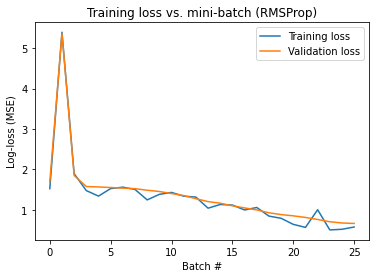

gamma=0.001, eta=0.0001, batch_size=160


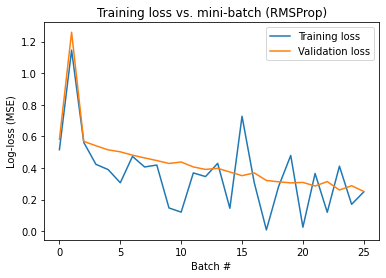

In [8]:
N = 160
gamma = 0.001
for eta in etas:
    print(f"gamma={gamma}, eta={eta}, batch_size={N}")
    _, _, rmsprop_plot = train(model, train_dataset, val_dataset, 1, opt="RMSProp", gamma=gamma, eta=eta, N=N)

## Adam optimizer

gamma=0.001, eta=0.01, batch_size=160


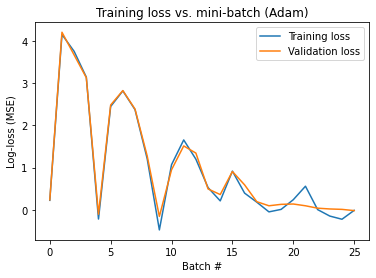

gamma=0.001, eta=0.001, batch_size=160


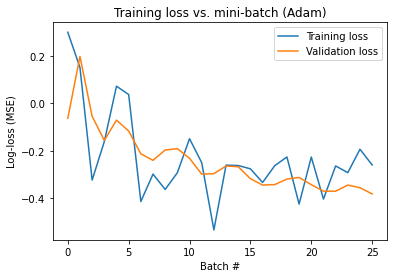

gamma=0.001, eta=0.0001, batch_size=160


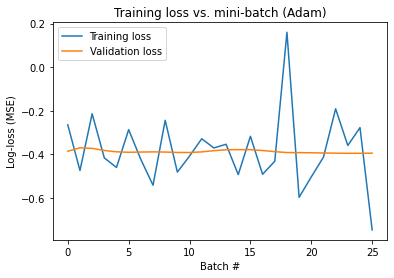

In [9]:
for eta in etas:
    print(f"gamma={gamma}, eta={eta}, batch_size={N}")
    _, _, adam_plot = train(model, train_dataset, val_dataset, 1, opt="Adam", gamma=gamma, eta=eta, N=N)

# Learning rate test
## RMSProp optimizer

gamma=0.001, eta=0.01, batch_size=160


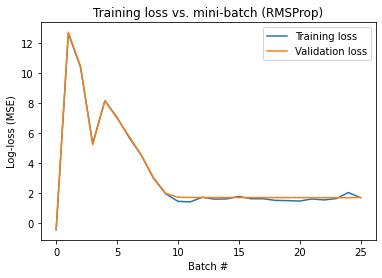

gamma=0.001, eta=0.001, batch_size=160


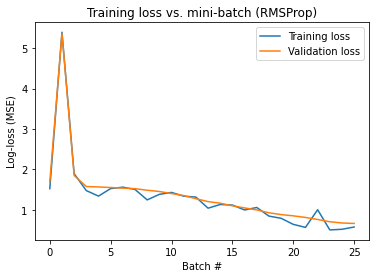

gamma=0.001, eta=0.0001, batch_size=160


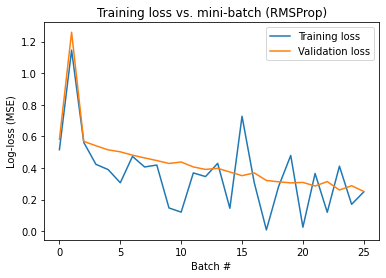

In [8]:
N = 160
gamma = 0.001
for eta in etas:
    print(f"gamma={gamma}, eta={eta}, batch_size={N}")
    _, _, rmsprop_plot = train(model, train_dataset, val_dataset, 1, opt="RMSProp", gamma=gamma, eta=eta, N=N)

## Adam optimizer

gamma=0.001, eta=0.01, batch_size=160


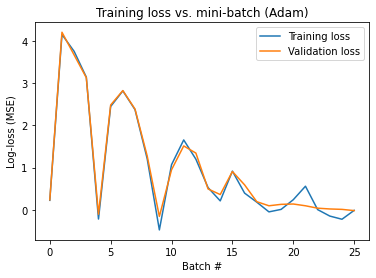

gamma=0.001, eta=0.001, batch_size=160


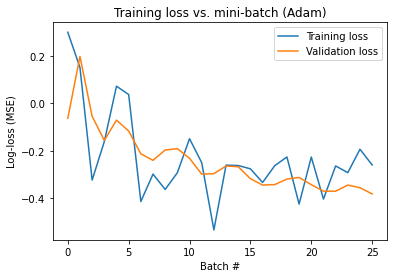

gamma=0.001, eta=0.0001, batch_size=160


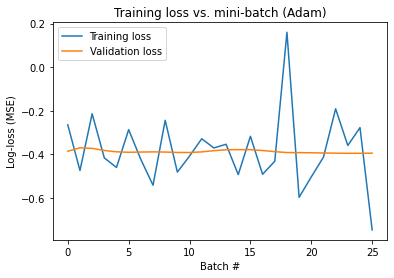

In [9]:
for eta in etas:
    print(f"gamma={gamma}, eta={eta}, batch_size={N}")
    _, _, adam_plot = train(model, train_dataset, val_dataset, 1, opt="Adam", gamma=gamma, eta=eta, N=N)

# Batch size test
## RMSProp optimizer

gamma=0.001, eta=0.001, batch_size=16


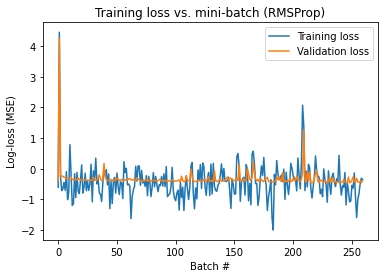

gamma=0.001, eta=0.001, batch_size=160


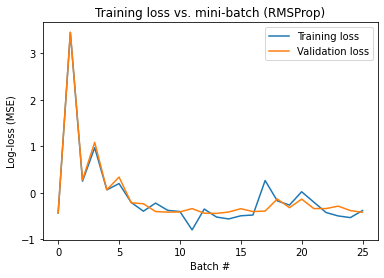

gamma=0.001, eta=0.001, batch_size=1600


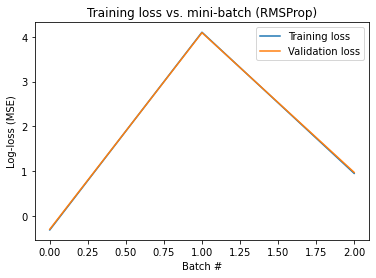

In [10]:
gamma = 0.001
eta = 10**-3
for N in Ns:
    print(f"gamma={gamma}, eta={eta}, batch_size={N}")
    _, _, rmsprop_plot = train(model, train_dataset, val_dataset, 1, opt="RMSProp", gamma=gamma, eta=eta, N=N)

## Adam optimizer

gamma=0.001, eta=0.001, batch_size=16


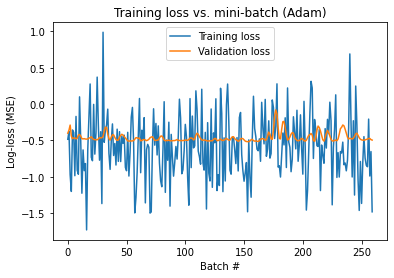

gamma=0.001, eta=0.001, batch_size=160


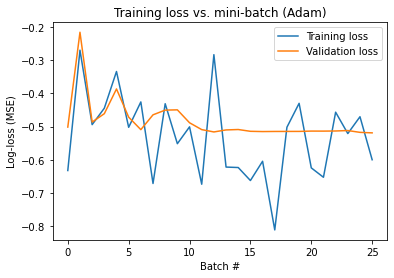

gamma=0.001, eta=0.001, batch_size=1600


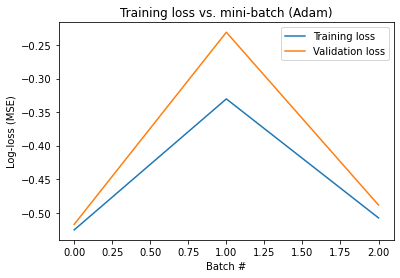

In [12]:
for N in Ns:
    print(f"gamma={gamma}, eta={eta}, batch_size={N}")
    _, _, adam_plot = train(model, train_dataset, val_dataset, 1, opt="Adam", gamma=gamma, eta=eta, N=N)

# Problem 4

In [72]:
# setup

## load MNIST data
train_set,test_set,train_loader,test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])
train_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader['mnist'] = torch.utils.data.DataLoader(train_set['mnist'], batch_size=len(train_set['mnist']), shuffle=True, num_workers=0)
test_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader['mnist'] = torch.utils.data.DataLoader(test_set['mnist'], batch_size=len(test_set['mnist']), shuffle=False, num_workers=0)

In [76]:
## separate into training/test datasets
## reshape into Nx784 datasets
batch, y_train = next(iter(train_loader['mnist']))
mnist_train = batch.view(batch.size(0), 784)
batch, y_test = next(iter(test_loader['mnist']))
mnist_test = batch.view(batch.size(0), 784)

In [116]:
# build logistic regression model
lr = 100
lambda = 0
model = nn.Linear(in_features=784, out_features=10, bias=True)
criterion = nn.CrossEntropyLoss()

#all_params = torch.cat([param.view(-1) for param in model.parameters() if param.requires_grad])
#print(all_params)
for i in range(1):
    y_hat = model(mnist_train)
    loss = criterion(y_hat, y_train)# + lambda*(sum squared of parameters)
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        for p in model.parameters():
            p.data = p - lr * p.grad.data
            print(p.data)

tensor([[ 0.0166,  0.0548,  0.0584,  ...,  0.0396,  0.0741,  0.0187],
        [ 0.1833,  0.1596,  0.1391,  ...,  0.1773,  0.1784,  0.1325],
        [ 0.3546,  0.3609,  0.3858,  ...,  0.3915,  0.3508,  0.3821],
        ...,
        [-1.5383, -1.4911, -1.5255,  ..., -1.4844, -1.5112, -1.5218],
        [ 0.6698,  0.6486,  0.6670,  ...,  0.6860,  0.6738,  0.6586],
        [ 0.2284,  0.2398,  0.2466,  ...,  0.2305,  0.2706,  0.2271]])
tensor([-0.0971, -0.4256, -0.8351, -5.4293,  4.7397, -1.0635,  1.7010,  3.5863,
        -1.6116, -0.5865])


In [138]:
[print(param.shape) for param in model.parameters()]

torch.Size([10, 784])
torch.Size([10])


[None, None]